In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
# Visualize data
def visualize_data(X, y, title=''):
    colors_dict = {0: 'purple', 1: 'yellow'}

    for color in colors_dict.keys():
        idx = np.where(y == color)
        plt.scatter(X[idx, 0], X[idx, 1], c=colors_dict[color], label=color)
    
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
# Generate moons dataset
X, y = make_moons(n_samples=100, noise=0.05, random_state=42)

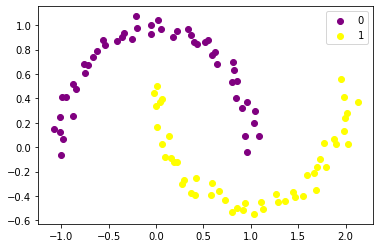

In [4]:
visualize_data(X, y)

In [5]:
def generate_V_matrix(X):
    # max_dims are the upper bounds of each dimension.
    # Since there is not clear specification on which values have to be picked,
    # using the maximum for each dimension should be a good choice
    max_dims = np.max(X, axis=0)

    V = np.array([[np.prod(max_dims - np.maximum(x_i, x_j)) for x_j in X] for x_i in X])

    return V


def lusi_algorithm(X, y, invariant_funcs, use_v_matrix=False, gamma=0.001, rbf_gamma=None):
    n = len(y)

    # Compute V matrix and Gramm matrix
    V = generate_V_matrix(X) if use_v_matrix else np.eye(n)
    K = rbf_kernel(X, gamma=rbf_gamma)

    # Create auxiliar variables
    ones = np.ones(n)
    VK = np.dot(V, K)
    VK_perturbed_inv = np.linalg.inv(VK + gamma * np.eye(n))

    # Compute invariants and store them as columns in a 2D array
    invariant_args = {'X': X, 'y': y}
    invariants = np.array([func(**invariant_args) for func in invariant_funcs]).T

    # Compute vectors
    # A_s is a 2D array whose columns contain the individual A_s values
    A_v = np.dot(VK_perturbed_inv, np.dot(V, y))
    A_c = np.dot(VK_perturbed_inv, np.dot(V, ones))
    A_s = np.dot(VK_perturbed_inv, invariants)

    # Create system of equations
    c_1 = np.dot(ones, np.dot(VK, A_c)) - np.dot(ones, np.dot(V, ones))
    mu_1 = np.dot(ones, np.dot(VK, A_s)) - np.dot(ones, invariants)
    rh_1 = np.dot(ones, np.dot(VK, A_v)) - np.dot(ones, np.dot(V, y))

    c_2 = np.dot(A_c, np.dot(K, invariants)) - np.dot(ones, invariants)

    # A_s has to be transposed so that dimensions match when performing the dot
    # product
    mu_2 = np.dot(A_s.T, np.dot(K, invariants))
    rh_2 = np.dot(A_v, np.dot(K, invariants)) - np.dot(y, invariants)

    B = np.block([[c_1, mu_1], [c_2.reshape(-1, 1), mu_2]])
    rh = np.hstack([rh_1, rh_2])
    solution = np.linalg.solve(B, rh)

    c, mu = solution[0], solution[1:]

    # The sum can be replaced with a dot product
    A = A_v - c * A_c - np.dot(A_s, mu)

    return A, c

In [6]:
def visualize_decision_boundary(X, A, c, gamma=None, title=''):
    xx,yy = np.meshgrid(np.linspace(-2,3,200),np.linspace(-2,3,200))
    viz=np.c_[xx.ravel(),yy.ravel()]

    z = np.dot(A, rbf_kernel(X, viz, gamma=gamma)) + c

    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7)
    plt.gca().set_xlim([-2.,3.])
    plt.gca().set_ylim([-2.,3.])
    plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-2,3,-2,3),alpha=0.3, vmin=0, vmax=1)
    plt.contour(xx,yy,z.reshape((200,200)))
    
    plt.title(title)
    plt.gcf().set_size_inches((9,9))
    plt.show()

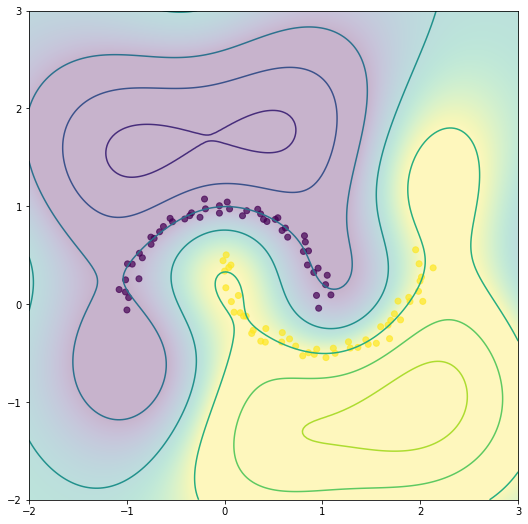

In [7]:
def my_invariant(**kwargs):
    return np.ones(len(y))


def my_invariant2(**kwargs):
    return X[:, 0]**2 + X[:, 1]**2

A, c = lusi_algorithm(X, y, [my_invariant, my_invariant2], use_v_matrix=True)
visualize_decision_boundary(X, A, c)